# Weight Visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

import utils
from MLP_model import MLP
from CNN_models import CNN_for_weight_visualization

%load_ext autoreload
%autoreload 2

In [2]:
max_epoch = 40

In [3]:
utils.set_random_seed(42)

In [4]:
dataset = dsets.SVHN(root='data/', download=True, transform=transforms.ToTensor())
testset = dsets.SVHN(root='data/', download=True, split="test", transform=transforms.ToTensor())

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [5]:
# We use about 20% of the dataset for validation.
val_size = 10000
train_size = len(dataset) - val_size
batch_size = 128

print("Single Sample Shape: ", dataset[0][0].size())

trainset, valset = random_split(dataset, [train_size, val_size])
print("Data sizes after random splitting -> \nTrain data size = {} \nValidation data size = {} \nTest data size = {}".format(len(trainset),len(valset), len(testset)))

train_loader = DataLoader(trainset, batch_size, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(valset, batch_size)
test_loader = DataLoader(testset, batch_size)

print("Total number of batches in one epoch (Train):", len(train_loader))
print("Total number of batches in one epoch (Validation):", len(val_loader))
print("Total number of batches in one epoch (Test):", len(test_loader))

Single Sample Shape:  torch.Size([3, 32, 32])
Data sizes after random splitting -> 
Train data size = 63257 
Validation data size = 10000 
Test data size = 26032
Total number of batches in one epoch (Train): 495
Total number of batches in one epoch (Validation): 79
Total number of batches in one epoch (Test): 204


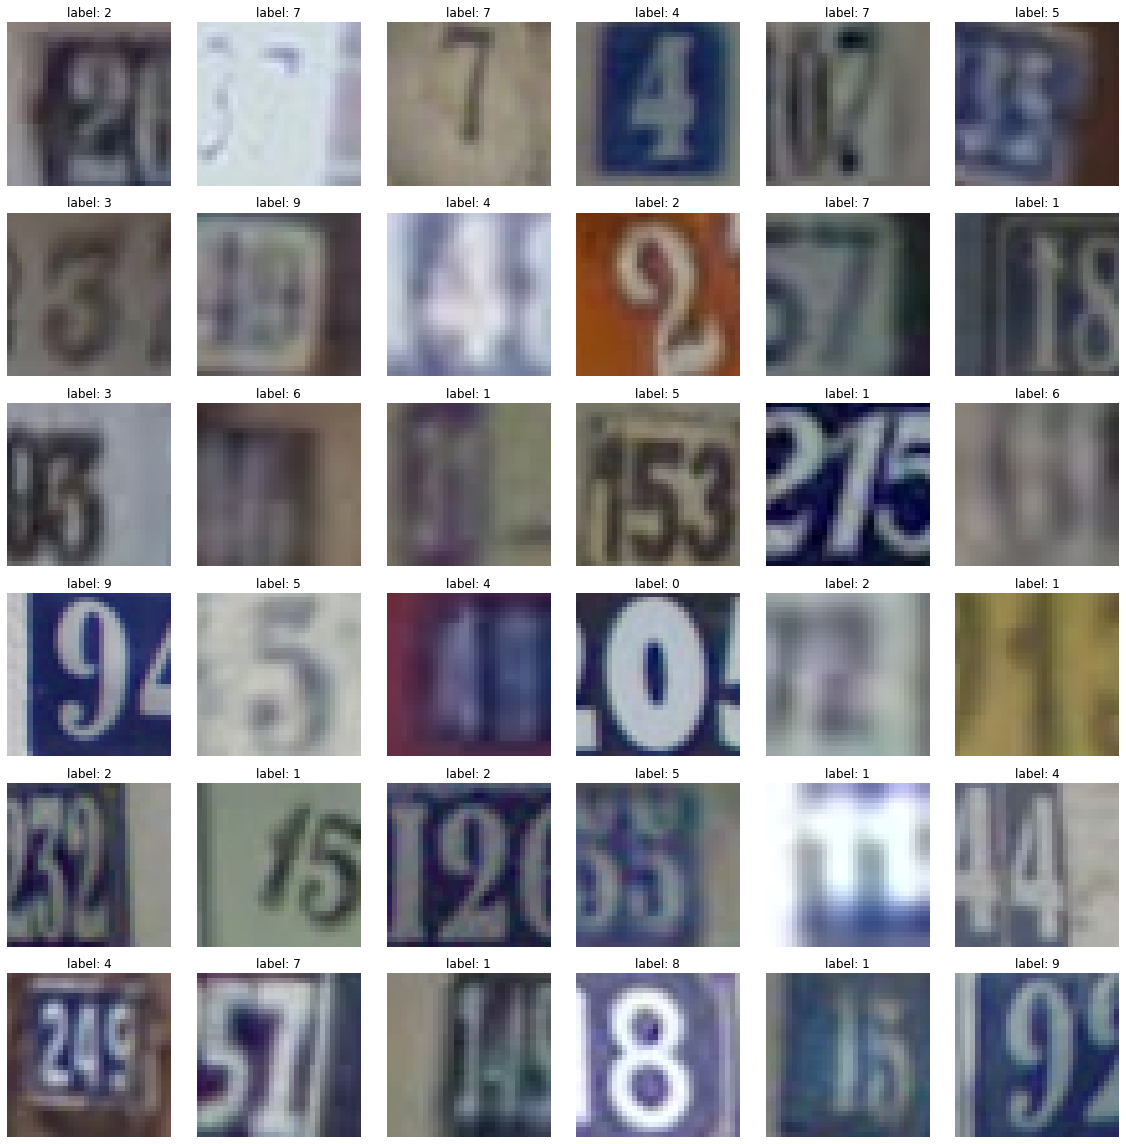

In [6]:
utils.visualize_data(trainset)

In [7]:
!nvidia-smi

Mon Nov 22 02:40:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8    18W /  N/A |   2004MiB / 16102MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is : {device}")

Device is : cuda


In [9]:
model = CNN_for_weight_visualization().to(device=device)
print(model)

CNN_for_weight_visualization(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=800, out_features=10, bias=True)
)


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = torch.nn.CrossEntropyLoss()
reg_params = None

train_loss, train_acc, val_loss, val_acc = utils.train(model, 
                                                 train_loader, 
                                                 val_loader, 
                                                 optimizer, 
                                                 loss_function, 
                                                 reg_function=None,
                                                 reg_params=reg_params,
                                                 max_epoch=max_epoch,
                                                 device=device)

test_loss, test_acc, confusion_matrix = utils.evaluate(model, test_loader, loss_function, device=device)
print("Test Loss : {} Test Acc: {}".format(test_loss, test_acc))

epoch 39 train acc: 0.8788 val acc: 0.8712 train loss: 0.4486 val loss: 0.4762: 


Time:  170.47606290498516
Test Loss : 0.5325656132955178 Test Acc: 0.8601281658496732


## Select A Sample for Visualization

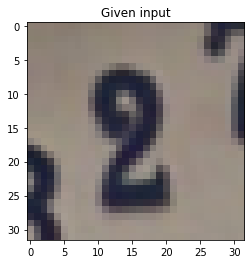

In [11]:
idx = 98
a_sample = dataset[idx][0][None, :, :, :].to(device) # pick a sample
output = model(a_sample, save_layer_outputs=True)
_=plt.imshow(a_sample[0].cpu().permute(1,2,0))
_=plt.title("Given input")

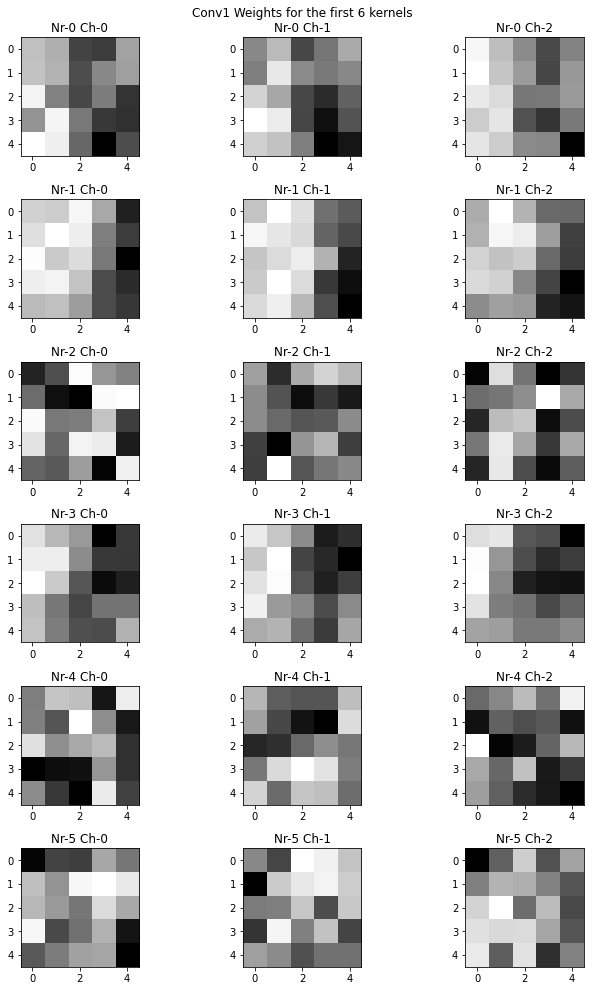

In [13]:
utils.visualize_weights(model.conv1.weight.detach().cpu().numpy()[:6,:,:,:], "Conv1 Weights for the first 6 kernels")

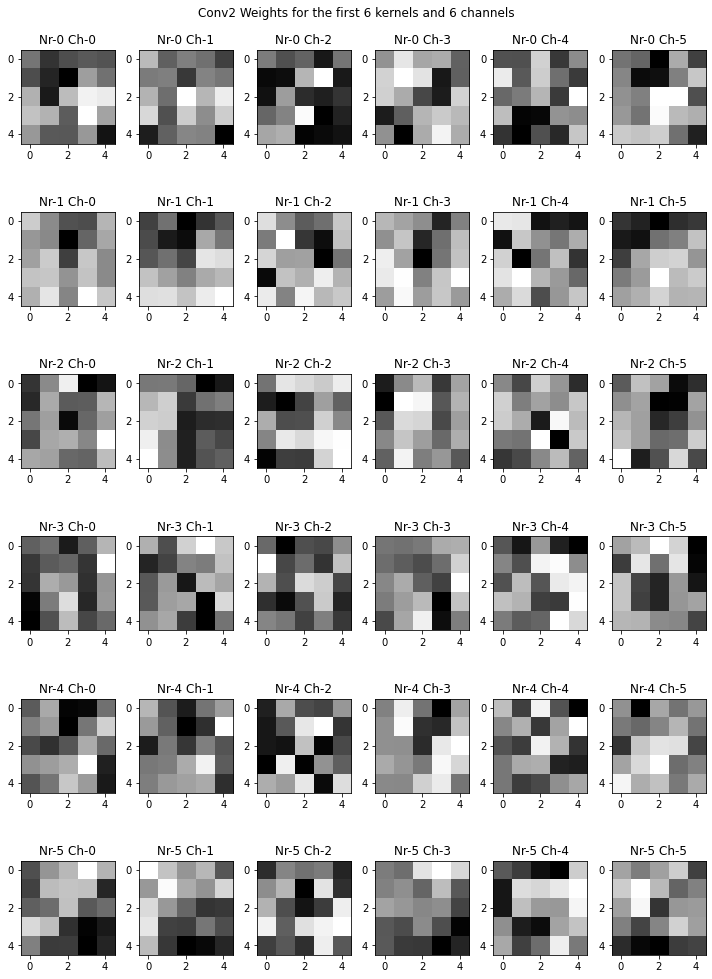

In [14]:
utils.visualize_weights(model.conv2.weight.detach().cpu().numpy()[:6,:6,:,:], "Conv2 Weights for the first 6 kernels and 6 channels")

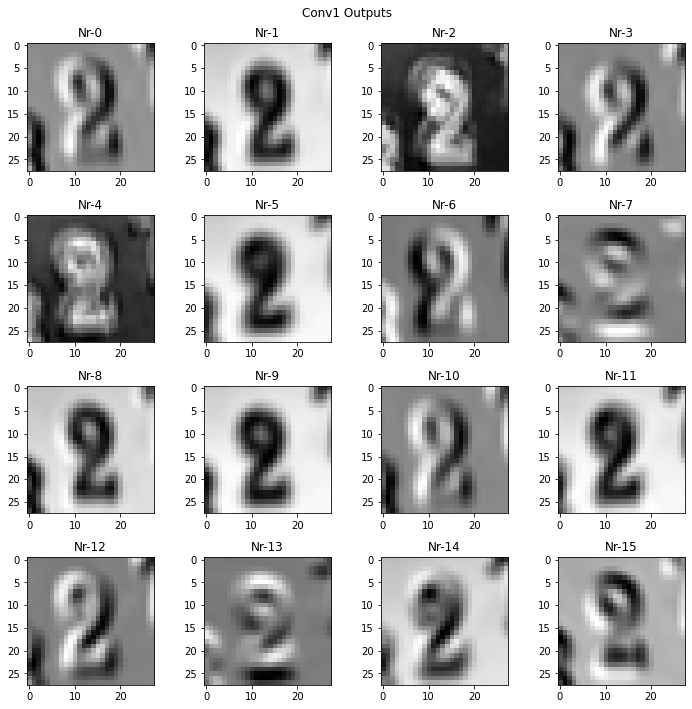

In [15]:
utils.visualize_activations(model.conv1_out, "Conv1 Outputs")

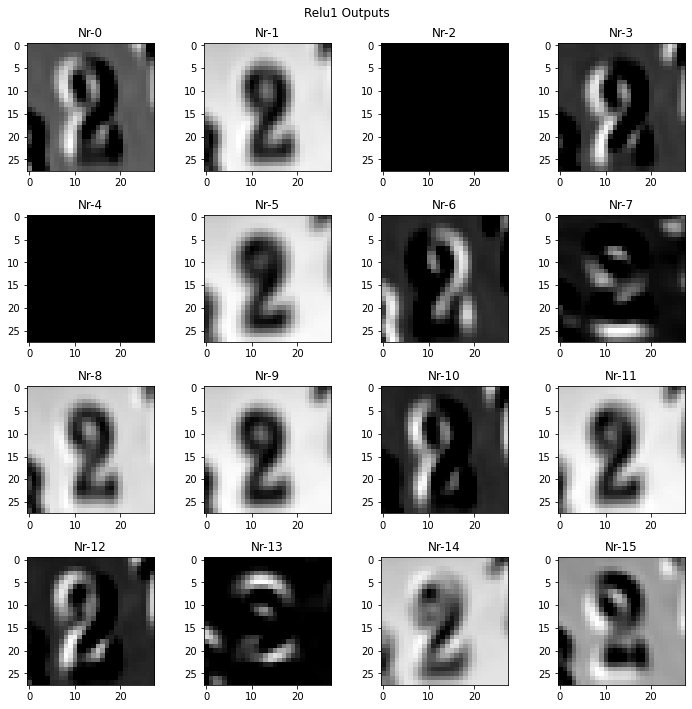

In [16]:
utils.visualize_activations(model.relu1_out, "Relu1 Outputs")

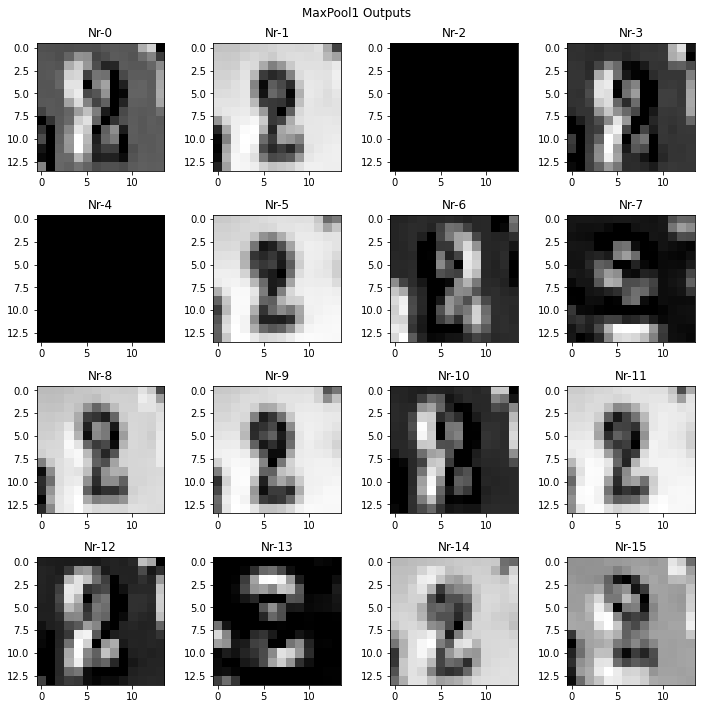

In [17]:
utils.visualize_activations(model.maxpool1_out, "MaxPool1 Outputs")

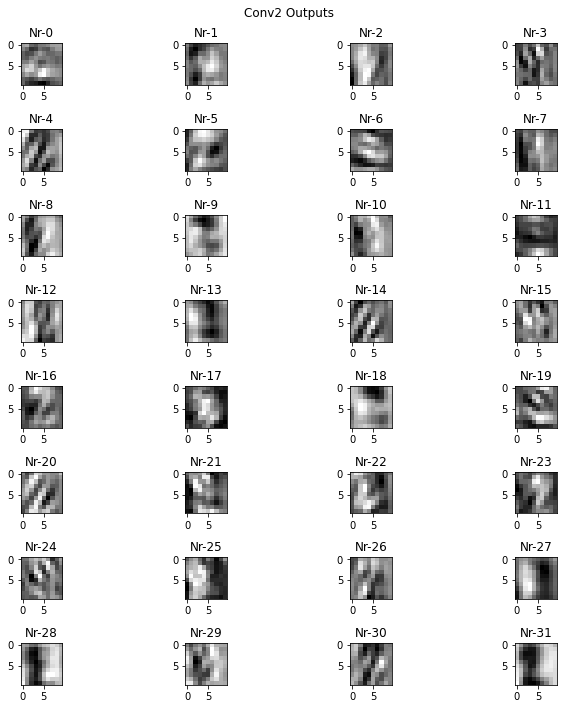

In [18]:
utils.visualize_activations(model.conv2_out, "Conv2 Outputs")

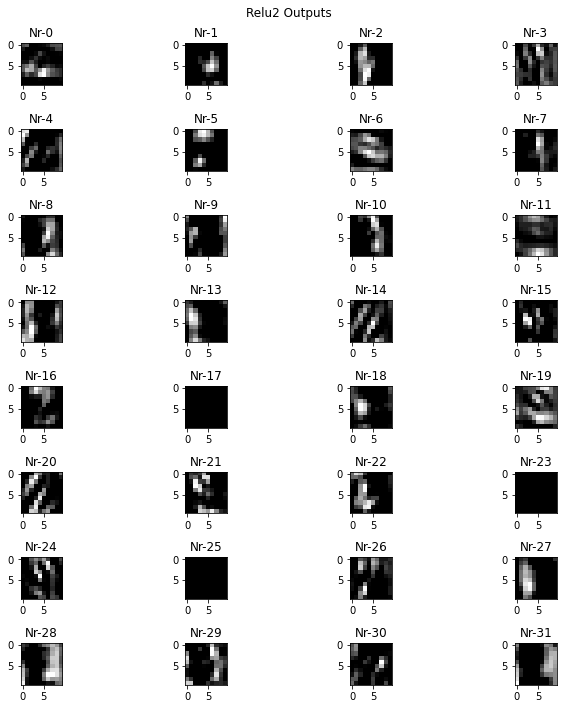

In [19]:
utils.visualize_activations(model.relu2_out, "Relu2 Outputs")

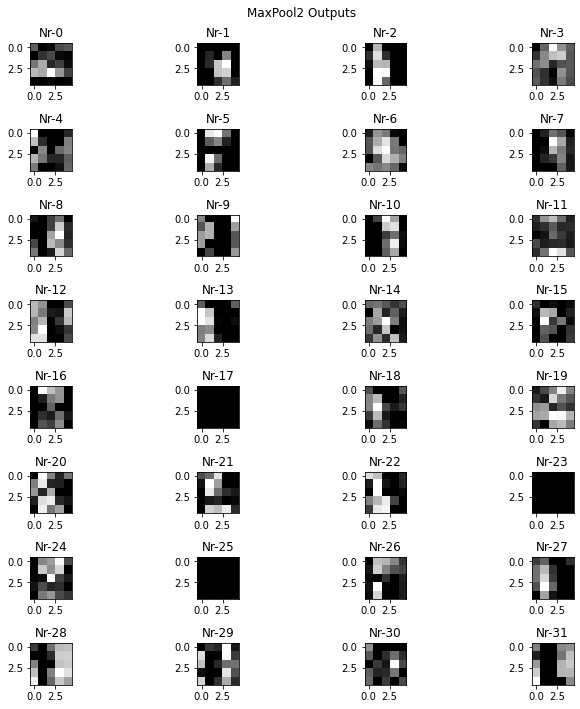

In [20]:
utils.visualize_activations(model.maxpool2_out, "MaxPool2 Outputs")